
# Decoding the representation of natural language from fMRI

*Written by Jiwoong Park, Hayoung Song, and Won Mok Shim*

Decoding the natural language that represents semantic/narrative content from the neural activation patterns is a topic of interest in the field of cognitive neuroscience. By analyzing the linear relationship between functional MRI (fMRI) of multiple subjects and the corresponding movie annotations ([Vodrahali et al., 2018](https://doi.org/10.1016/j.neuroimage.2017.06.042)) or speech ([Huth et al., 2016](https://doi.org/10.1038/nature17637)), recent studies have shown that semantic or narrative content can be decoded from neural response patterns.  

In this tutorial, we introduce a method for decoding narrative content from fMRI data, by building a simple linear regression model.

**Tutorial goals**
1. Learn how to convert natural language into a vector representation using a pretrained word embedding model
2. Learn how to decode natural language informaiton from fMRI data using a cross-validated, predictive model

# Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

## Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- matplotlib
- numpy
- scipy
- pandas
- sklearn
- nltk
- nibabel
- nilearn
- nltools
- requests
- datalad

Let's now load the modules we will be using for this tutorial.

In [70]:
# Import libraries and configurations.
import re
import csv
import os
import pickle
import glob

# for scientific computing and data visualization 
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import zscore
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# for natural language processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt') # Download package punkt if you don't have

# for machine learning
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics.pairwise import cosine_similarity

# for handling neuroimaging data
import nibabel as nib
from nilearn.plotting import view_img, view_img_on_surf
from nltools.data import Brain_Data
from nltools.external import glover_hrf
from nltools.mask import expand_mask, roi_to_brain

# for downloading data
import requests
import datalad.api as dl

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lukechang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data
We will use the **Paranoia** dataset of [Finn et al. (2018)](https://www.nature.com/articles/s41467-018-04387-2). This dataset consists of 22 participants' fMRI data, as they listened to a 22-minute audio-narrated story. Each participant's fMRI data contains three runs. The goal is moment-to-moment decoding of the natural language information from the corresponding fMRI responses.

You will want to change `data_dir` to wherever you have installed the Paranoia datalad repository (e.g. `~/data`). We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, you can skip this cell. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

Downloading all of the data could take a little while depending on the speed of your internet connection.

In [385]:
data_dir = '/Volumes/Engram/Data/Paranoia' # Change this for your computer

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(data_dir):
    dl.clone(source='https://gin.g-node.org/ljchang/Paranoia', path=datadir)

# Initialize dataset
ds = dl.Dataset(data_dir)

# # Get Cropped & Denoised Nifti Files
# result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*denoise_smooth6mm_task-story*nii.gz')))

# Get Average Time Series within Parcellation
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*_nodeTimeSeries.csv')))

# Get Forced Aligned transcripts
result = ds.get(glob.glob(os.path.join(data_dir, 'stimuli', 'paranoia_story*_transcript.txt')))


# Functional MRI data
To reduce the fMRI data's dimensionality, we extract the mean time course of the regions of interest (ROIs), which is defined using the whole-brain functional parcellation called the Shen atlas ([Shen et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S1053811913005818)), which has 268 parcels. Depending on the research purpose, other dimensionality reduction methods (e.g., PCA, ICA, SRM, etc.) can be chosen.

## Parcellation Atlas
Let's visualize the Shen et al., 2013 Parcellation scheme. Here, we download the mask directly from [neurovault](https://neurovault.org/images/395091/) using `nltools` and then plot with `nilearn`.



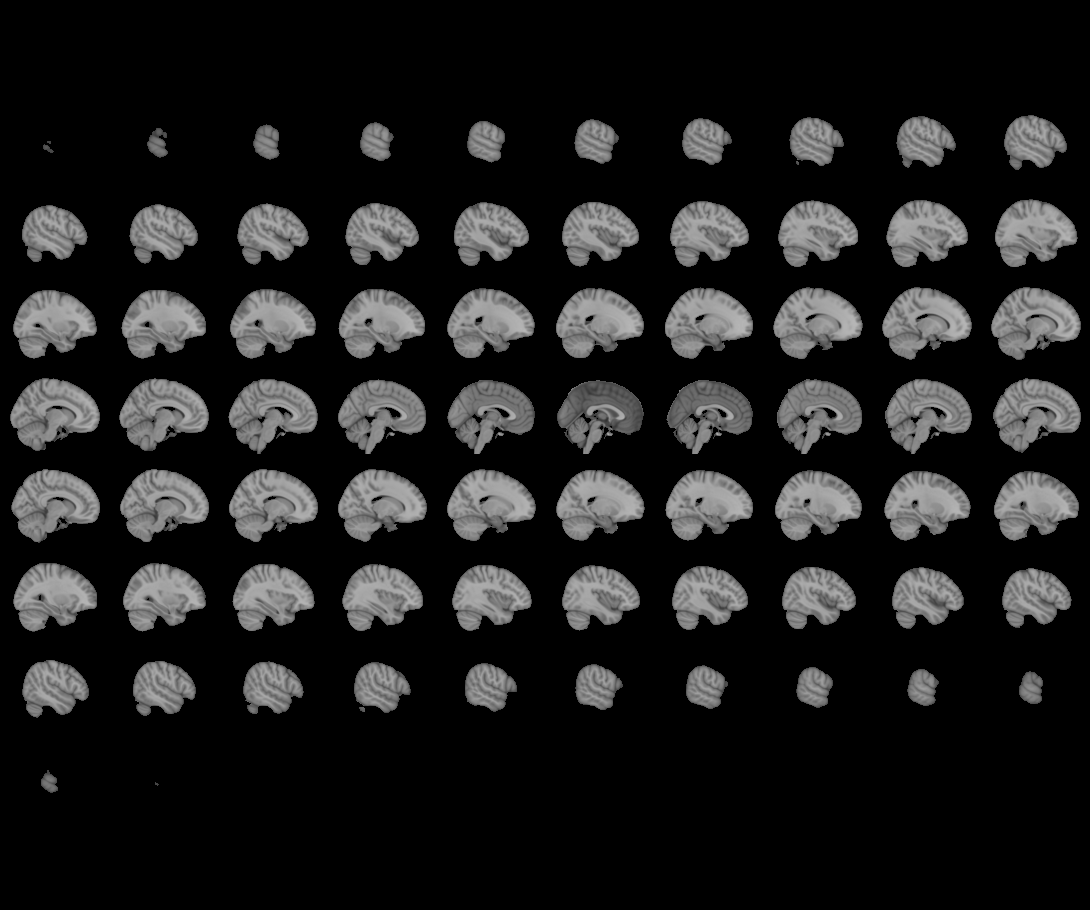
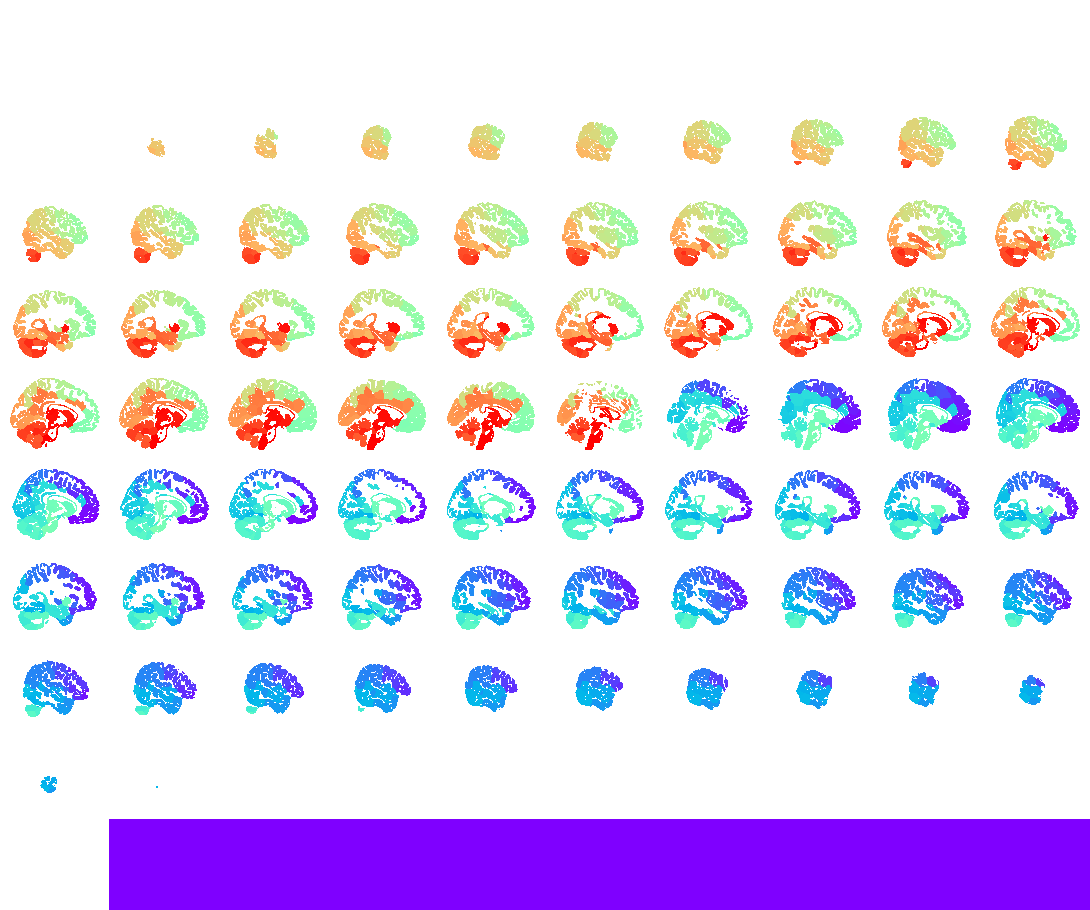

In [4]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')

view_img(mask.to_nifti(), symmetric_cmap=False, cmap='rainbow')

## Mean time course of ROIs
Next, we will extract the mean time course from all voxels in each ROI.

The original fMRI data is 4D `(91, 109, 91, 1310)`, which corresponds to `(x, y, z, time)`. The Shen Atlas has 268 ROIs, so the dimensions of the reduced data should be `(1310, 268)`. 

Next, we'll create node time series for all subjects for all runs. There are 22 subjects, each with 3 runs, so this will take a little while (~45 min). To speed this up, we have already run the code and shared the extracted csv files in the datalad repository. If you would like to run this yourself, make sure you have the correct data downloaded and paste this code into a new cell and run it. 

```python
subj_list = behav_data["participant_id"]

for subj in subj_list:    
    for run in [1, 2, 3]:
        time_series_fname = os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')
        if os.path.exists(time_series_fname):
            print(f"Node time series file for {subj}, run {run} already exists!")
        else:
            print(f"Creating node time series for {subj}, run {run}")
            time_series = masker.fit_transform(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_denoise_smooth6mm_task-story_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
            pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

```

In [6]:
behav_data = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')

subj_list = behav_data["participant_id"]

fmri_data = []
for subj in subj_list:
    sub_data = []
    for run in range(1,4):
        sub_data.append(pd.read_csv(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')))
    sub_data = pd.concat(sub_data)
    fmri_data.append(sub_data.values)
fmri_data = np.array(fmri_data)

print(fmri_data.shape)

(22, 1310, 268)


Ok, looks like our data loaded correctly. We have 22 subjects x 1310 TRs (which is the number of timepoints in across all runs) x 268 parcels.

## Visualize fMRI data (Time points, ROIs)
Your fMRI data should now be a matrix of `(n_samples, n_features)`.

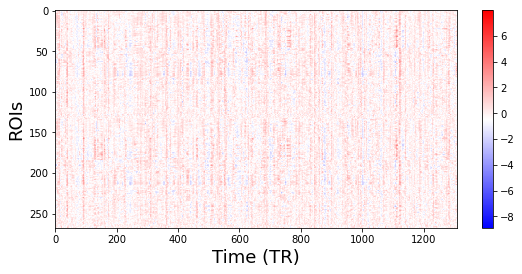

In [7]:
sub_num = 0 # Specify which subject you want to visualize. 
plt.figure(figsize=(9,4))

# Transpose the matrix in order to put Time on the X axis.
plt.imshow(fmri_data[sub_num].T, aspect='auto', cmap='bwr')
plt.xlabel('Time (TR)', fontsize=18)
plt.ylabel('ROIs', fontsize=18)
plt.colorbar()

# Word embedding

Next, we transform natural language information from the Paranoia transcript into vector representations using natural language processing (NLP) to represent the semantic meanings of the story quantitatively. We have performed forced alignment to get the onset of each word using the [Pliers](https://github.com/tyarkoni/pliers) toolbox in the [Automated Annotation](http://naturalistic-data.org/features/notebooks/Pliers_Tutorial.html) tutorial. To represent each word in the Paranoia stimuli, we use a pretrained word embedding model. The purpose is to project each word into a point in a multi-dimensional embedding space, so that it retains its semantic relationship with all other words. 

## GloVe: Pretrained word embedding
The `GloVe: Global Vectors for Word Representation` is a widely used word embedding algorithm ([Pennington, Socher & Manning, 2014](https://nlp.stanford.edu/pubs/glove.pdf)). GloVe provides pretrained word vectors made from a variety of large corpus. You can check more information and download pretrained models [here](https://nlp.stanford.edu/projects/glove/). 

We will use the `glove.6B.100d.txt` model, which contains a feature dimensionality of 100.This file is 862mb to [download](https://nlp.stanford.edu/pubs/glove.pdf). You can download the file, unzip, and then load using the `get_glove_model` function. This is a good idea if you plan to work with this file repeatedly. However, for this tutorial, we will load the file directly from a url, which is easier, but will be slower in the long term if you repeatedly work the model.

In [14]:
def get_glove_model(url):
    '''Load glove.6B.100d model from URL or File
    
    Args:
        url: (str) either a url to text file, or a path to a local file
        
    Return:
        glove embeddings: (dict) glove embeddings
    '''

    pre_glove_100 = {}
    if 'http:' in url or 'https:' in url:
        page = requests.get(url)

        pre_glove_100 = {}
        split_text = page.text.split('\n')
        for line in split_text:
            split_line = line.split(' ')
            pre_glove_100[split_line[0]] = np.array([float(x) for x in split_line[1:]])
    else:
        with open(url, 'r', encoding='utf-8') as glove_file:
            for line in glove_file:
                split_line = line.split()
                pre_glove_100[split_line[0]] = np.array([float(x) for x in split_line[1:]])
    return pre_glove_100

url = 'http://cosanlab.host.dartmouth.edu/files/glove.6B.100d.txt'

pre_glove_100 = get_glove_model(url)

If a vector representation of each word reflects its semantic information, semantically similar words should have similar vector representations. 

Now we will check what they look like.

shape of the word vector [cheese] is:  (100,)


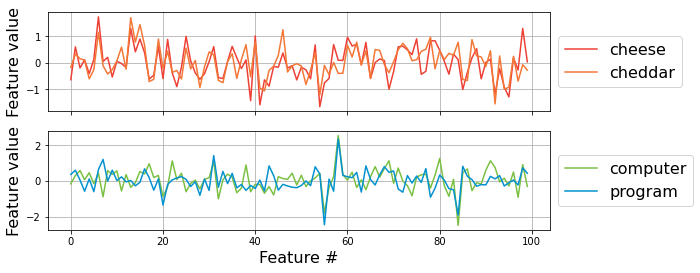

In [16]:
vector_of_cheese = pre_glove_100['cheese']                                                                           
print("shape of the word vector [cheese] is: ", vector_of_cheese.shape)

f,a = plt.subplots(nrows=2, figsize=(9,4), sharex=True)
a[0].plot(pre_glove_100['cheese'].ravel(), c='#ee4035', label='cheese')
a[0].plot(pre_glove_100['cheddar'].ravel(), c='#f37736', label='cheddar')
a[0].legend(bbox_to_anchor=(1, .5), loc='center left', ncol=1, fontsize=16)
a[0].set_ylabel('Feature value', fontsize=16)
a[0].grid()

a[1].plot(pre_glove_100['computer'].ravel(), c='#7bc043', label='computer')
a[1].plot(pre_glove_100['program'].ravel(), c='#0392cf', label='program')
a[1].legend(bbox_to_anchor=(1, .5), loc='center left', ncol=1, fontsize=16)
a[1].set_ylabel('Feature value', fontsize=16)
a[1].set_xlabel('Feature #', fontsize=16)
a[1].grid()


## Preprocessing the Paranoia transcript
We will use transcripts, which have been forced aligned using the [rev.ai](https://www.rev.ai/) API accessed via [Pliers](https://github.com/tyarkoni/pliers) (see the [Automated Annotation](http://naturalistic-data.org/features/notebooks/Pliers_Tutorial.html) Tutorial for more details). 

In this step, we will apply basic data cleaning and preprocessing to the words before projecting them into the embedding space (e.g., removing non-letters, making lowercase).

We will concatenate each run so that the timings match the fMRI data. We need to add 3 seconds on to each onset time to account for the delay in the stimuli presentation at the start of each run. In addition, we will add the length of the previous run to ensure that the onsets are sequential for each story.

In [260]:
def clean_text(text):
    return re.sub(r"[^A-Za-z ']+", '', text).lower()

run_duration = {1:526, 2:452, 3:332}

paranoia_transcript = []
for run in range(1,4):
    run_file = pd.read_csv(os.path.join(data_dir, 'stimuli', f'paranoia_story{run}_transcript.txt'), sep='\t')
    run_file['onset'] = run_file['onset'] + 3
    
    if run == 2:
        run_file['onset'] = run_file['onset'] + run_duration[1]
    if run == 3:
        run_file['onset'] = run_file['onset'] + run_duration[1] + run_duration[2]

    paranoia_transcript.append(run_file)

paranoia_transcript = pd.concat(paranoia_transcript)

paranoia_transcript['clean_text'] = paranoia_transcript.apply(lambda row: clean_text(row['text']), axis=1)

paranoia_transcript.head()

onset   text  duration clean_text
0   5.09    The      0.21        the
1   5.30  email      0.36      email
2   5.66   came      0.42       came
3   6.11   late      0.27       late
4   6.38    one      0.24        one

So now, we have 3452 words, along with their onset times and durations.

To map this to the fMRI data, the data matrix should be (1310, 100), which corresponds to (number of TRs, number of features).

You could simply take the average of the embedding vectors of all words in each sentence, then assign this average vector for the duration of the corresponding sentence (from onset to offset).

However, because the participants listened to each word in the audio-narrated story in order, we can adopt a more reasonable method from [Huth et al. (2016)](https://doi.org/10.1038/nature17637), in which they placed each word vector at the onset time of the corresponding word and downsampled the data points to match the fMRI data's low temporal resolution. 

We ignore words that cannot be projected into the GloVe embedding space (e.g., proper nouns).

In [281]:
word_embedding = []
error_keys = []
word_time = []
for row in paranoia_transcript.iterrows():
    
    onset = row[1]['onset']
    word = row[1]['clean_text']
    
    try:   # Check if the word can be projected
        word_embedding.append(pre_glove_100[word])
        word_time.append({'onset':onset, 'word': word})
    except KeyError:  
        valid = False
        error_keys.append(word) # Ignored words

print('------------------Error keys(cannot be embedded)-----------------')
print(set(error_keys))

word_embedding = pd.concat([pd.DataFrame(word_time), pd.DataFrame(word_embedding)], axis=1)

------------------Error keys(cannot be embedded)-----------------
{"didn't", "hadn't", "don't", "maria's", 'tarson', "i'll", "wouldn't", "weren't", 'torson', "wasn't", "that's", "i've", "juan's", 'flipflops', "i'm", "alba's", "family's", "carmen's", "it's", "man's", 'batched', 'united states', "she'd", 'wellstocked', 'omelas', "he'd"}


## Resampling the word vectors
We now have 3451 word vectors in an embedding dimension of 100. Let us visualize the process of resampling using the first 100 words on the first feature dimension.

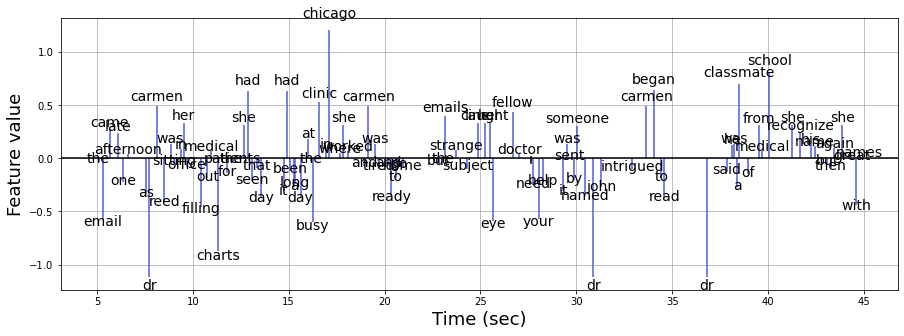

In [170]:
n_words = 100   # first 100 words
feature = 0     # first feature

plt.figure(figsize=(15,5))
plt.axhline(0, c='k')
plt.vlines(word_embedding['onset'][:n_words], [0], 
           word_embedding.iloc[:n_words, feature + 2], color='#4f5bd5', label='word vectors')
# The blue peak represents each word

for i in range(n_words):
    plt.text(word_embedding['onset'][i], 1.1*word_embedding.iloc[i, feature+2], 
             s=word_embedding['word'][i], ha='center', fontsize=14)

plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Feature value', fontsize=18)
plt.grid()

Next, we need to downsample the word vector to the scale of the fMRI data. Here, we use a linear interpolation function. The red line represents the downsampled signal. 

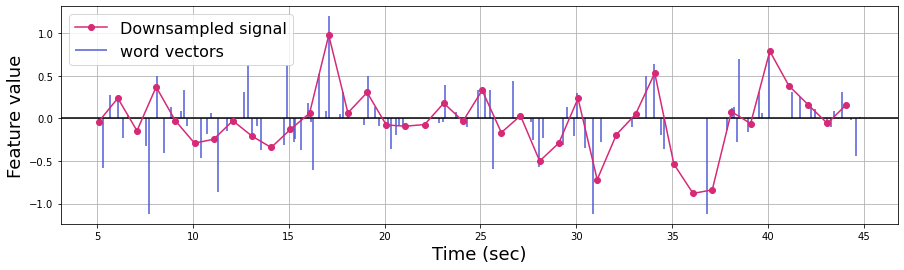

In [171]:
plt.figure(figsize=(15,4))
plt.axhline(0, c='k')
plt.vlines(word_embedding['onset'][:n_words], [0], 
           word_embedding.iloc[:n_words, feature+2], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_embedding['onset'][:n_words], 
                             word_embedding.iloc[:n_words, feature+2], kind='linear')

TR_time = np.arange(np.min(word_embedding['onset'][:n_words]), np.max(word_embedding['onset'][:n_words])) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Feature value', fontsize=18)
plt.grid()

We convolve this downsampled signal with the hemodynamic response function (HRF) to obtain temporally lagged fMRI responses. We will be using the Glover double gamma HRF.

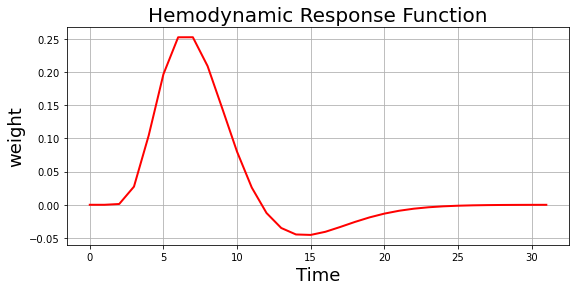

In [172]:
hrf_weight = glover_hrf(1, oversampling=1)

plt.figure(figsize=(9,4))
plt.plot(hrf_weight, 'r-', linewidth=2)
plt.ylabel('weight', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Hemodynamic Response Function', fontsize=20)
plt.grid()

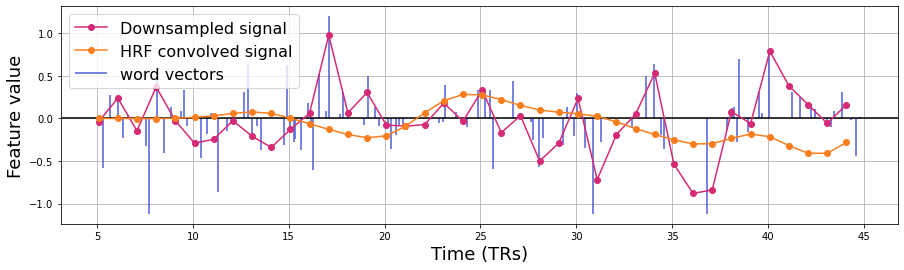

In [173]:
plt.figure(figsize=(15,4))
plt.axhline(0, c='k')
plt.vlines(word_embedding['onset'][:n_words], [0], 
           word_embedding.iloc[:n_words, feature+2], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_embedding['onset'][:n_words], 
                             word_embedding.iloc[:n_words, feature+2], kind='linear')

TR_time = np.arange(np.min(word_embedding['onset'][:n_words]), np.max(word_embedding['onset'][:n_words])) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

plt.plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')

# Convolve HRF
convolved = np.convolve(downsampled_vector, hrf_weight, mode='full')[:len(downsampled_vector)]
plt.plot(TR_time, convolved, 'o-',color='#fa7e1e', label='HRF convolved signal')

plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Time (TRs)', fontsize=18)
plt.ylabel('Feature value', fontsize=18)
plt.grid()


Apply the steps above to all features in the embedding space.

In [252]:
def downsample_embeddings(word_embeddings, kind='linear', convolve_hrf=True):
    '''Downsample word embeddings dataframe to TR and convolve with HRF'''
    
    word_time = word_embeddings['onset']
    embeddings = word_embeddings.iloc[:, 2:]
    linear_downsample = interp1d(word_time, embeddings, kind=kind, axis=0)
    TR_time = np.arange(np.min(word_time), np.max(word_time), 1) # Specify the number of time points
    downsampled_vector = linear_downsample(TR_time)
    downsampled_vector = np.nan_to_num(downsampled_vector, nan=0) # Replace NaNs with zeros for convolution
    downsampled_vector = np.concatenate([np.zeros((5, n_feature)), downsampled_vector, np.zeros((2, 100))], axis=0) # Pad beginning and end with zeros

    if convolve_hrf:
        return np.array([np.convolve(x, hrf_weight)[:len(x)] for x in downsampled_vector.T]).T
    else:
        return downsampled_vector
    
n_TR = 1310
n_feature = 100

paranoia_embedding = downsample_embeddings(word_embedding)

# Linear decoding model
## Decoding natural language from the fMRI data (using cross-validation across subjects)
Finally, we have the fMRI data of (1310, 268), and the natural language data of (1310, 100). 

We use a linear model to learn the relationship between the fMRI responses and word embeddings computed from the Paranoia transcript. To do this, we employ a leave-one-subject-out cross-validation approach. In other words, we train a linear model with all time points for all subjects but one and test the model on the held-out participants' fMRI time course. The fMRI responses (x) are different for the 22 participants, but the word embedding time course (y) is the same.  

We predict the word embedding vector of each time point and measure its similarity (i.e., cosine similarity) with the observed vector. The decoding is successful if the similarity between the predicted and corresponding observed word vectors is ranked within the top-N over the similarities between the predicted and observed word vectors at all other time steps. Here, we use top-10, meaning the decoding is successful if the similarity between the predicted and observed vectors is within a rank of 10 over 1310 other possible observed vectors. Thus, the chance level is 10 / 1310 * 100 = 0.763%.

In [249]:
sub_list = behav_data["participant_id"]


X = fmri_data
Y = zscore(paranoia_embedding, axis=0) # Normalize each feature dimension

n_top = 10
LOO = LeaveOneOut()

test_hit = []
test_similarity = []
map_coef = []

# Leave one subject out cross validation
for train_index, test_index in LOO.split(sub_list):
    print("TRAIN sub:", train_index, "TEST sub:", test_index)
    X_train = np.zeros((1310*len(train_index), 268))   # Train X(fMRI): (1310*21, 268)
    y_train = np.zeros((1310*len(train_index), 100))   # Train Y(Text): (1310*21, 100)
    for i, idx in enumerate(train_index):
        X_train[i*1310:(i+1)*1310, :] = X[idx, :, :]
        y_train[i*1310:(i+1)*1310, :] = Y
    X_test = X[test_index[0], :, ]                     # Test X(fMRI): (1310, 268)
    y_test = Y                                         # Test Y(Text): (1310, 100)
    
    reg = LinearRegression().fit(X_train, y_train)
    map_coef.append(reg.coef_)
    y_pred = reg.predict(X_test)
    similarity = cosine_similarity(y_pred, y_test)
    test_similarity.append(similarity)
    
    # Check if the predicted word embedding is ranked within the top 10
    hit = 0
    for j in range(similarity.shape[0]):        
        if j in similarity[j,:].argsort()[-n_top:][::-1]:
            hit += 1
    print('Test decoding acc.: {:0.3f}%'.format(100*hit/1310))
    print(' ')

    test_hit.append(hit)
test_similarity = np.array(test_similarity)
print(' ')
print('----------------------Average decoding acc.----------------------')
print('Average acc.: {:0.3f}%'.format((100*np.array(test_hit)/1310).mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))
map_coef = np.mean(map_coef, axis=0)

TRAIN sub: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [0]
Test decoding acc.: 4.198%
 
TRAIN sub: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [1]
Test decoding acc.: 2.366%
 
TRAIN sub: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [2]
Test decoding acc.: 3.206%
 
TRAIN sub: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [3]
Test decoding acc.: 4.733%
 
TRAIN sub: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [4]
Test decoding acc.: 4.733%
 
TRAIN sub: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [5]
Test decoding acc.: 2.672%
 
TRAIN sub: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [6]
Test decoding acc.: 1.908%
 
TRAIN sub: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [7]
Test decoding acc.: 3.664%
 
TRAIN sub: [ 0  1  2  3  4  5  6  7  9 10 11 12 

Next, we will visualize the similarity between the predicted and observed word vectors for all time points (averaged across subjects). 

For the decoding to be successful, the similarity between the predicted and observed vectors should be higher than the similarity between the predicted and the other observed vectors at the rest of the time points. This should result in the higher diagonal values than the non-diagonal ones in the top figure. The bottom figure indicates the locations of the top 10 predicted indices.

Text(0.5, 1.0, 'Top 10 predicted index')

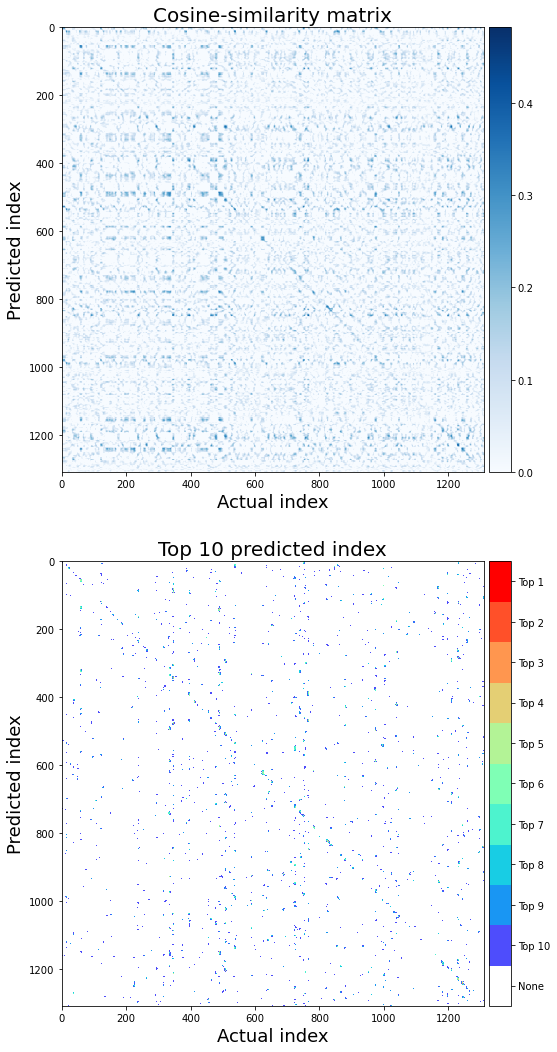

In [225]:
from matplotlib import colors, cm

cmap = cm.rainbow
cmaplist = [cmap(i) for i in range(cm.rainbow.N)]
cmaplist[0] = (1.0,1.0,1.0,1.0)
my_cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

n_top = 10
norm = colors.BoundaryNorm(np.arange(n_top+2), 256)
hit = 0

similarity = test_similarity.mean(axis=0)
hit_matrix = np.zeros(similarity.shape)
for j in range(similarity.shape[0]):
    for k, idx in enumerate(similarity[j,:].argsort()[-n_top:][::-1]):
        hit_matrix[j,idx] = n_top-k
        if j == k:
            hit +1
            
plt.figure(figsize=(9,18), facecolor='w')
plt.subplots_adjust(wspace=0.0)
plt.subplot(211)
plt.imshow(similarity, aspect='auto', cmap='Blues')
plt.ylabel('Predicted index', fontsize=18)
plt.xlabel('Actual index', fontsize=18)
plt.colorbar(pad=0.01)
plt.clim(0,None)
plt.title('Cosine-similarity matrix', fontsize=20)

plt.subplot(212)
plt.imshow(hit_matrix, aspect='auto', cmap=my_cmap, norm=norm)
plt.ylabel('Predicted index', fontsize=18)
plt.xlabel('Actual index', fontsize=18)
cb = plt.colorbar(pad=0.01)

labels = np.arange(0,11,1)
loc    = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(['None']+['Top '+str(n_top-l) for l in labels[:-1]])
plt.title('Top 10 predicted index', fontsize=20)

### Decoding scrambled words from fMRI (for baseline)
We will now create a baseline to check whether our model performance is specific to fMRI-text mapping. To do this, we scramble the order of the words in the story and relate them with the fMRI responses using the same linear mapping procedure. 

In [282]:
n_top = 10
n_iter = 20
scram_hit_iter = []
for iter in range(n_iter): # Number of iterations
    
    # Scramble the order of the words
    word_embedding_scram = pd.concat([word_embedding.loc[:,['onset', 'word']], word_embedding.iloc[np.random.permutation(word_embedding.shape[0]), 2:].reset_index(inplace=False, drop=True)], axis=1)   
    
    # Downsample and HRF convolve
    paranoia_embedding_scram = downsample_embeddings(word_embedding_scram)
    
    # Same linear mapping between the fMRI and scrambled word embeddings
    X = fmri_data
    Y = zscore(paranoia_embedding_scram, axis=0)
    
    scram_hit = []
    for train_index, test_index in LOO.split(sub_list):
        X_train = np.zeros((1310*len(train_index), 268))
        y_train = np.zeros((1310*len(train_index), 100))
        for i, idx in enumerate(train_index):
            X_train[i*1310:(i+1)*1310, :] = X[idx, :, :]
            y_train[i*1310:(i+1)*1310, :] = Y
        X_test = X[test_index[0], :, ]
        y_test = Y

        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        similarity = cosine_similarity(y_pred, y_test)
        hit = 0
        for j in range(similarity.shape[0]):
            if j in similarity[j,:].argsort()[-n_top:][::-1]:
                hit += 1
        scram_hit.append(hit)
    scram_hit_iter.append(100*np.array(scram_hit)/1310)

scram_hit_iter = np.array(scram_hit_iter)  

print('-----------------Average decoding acc. (Baseline)-----------------')
print('Average acc.: {:0.3f}%'.format(scram_hit_iter.mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))

-----------------Average decoding acc. (Baseline)-----------------
Average acc.: 2.372%
Chance acc.: 0.763%


The actual decoding is higher than the baseline decoding.

Text(0, 0.5, 'Decoding accuracy(%)')

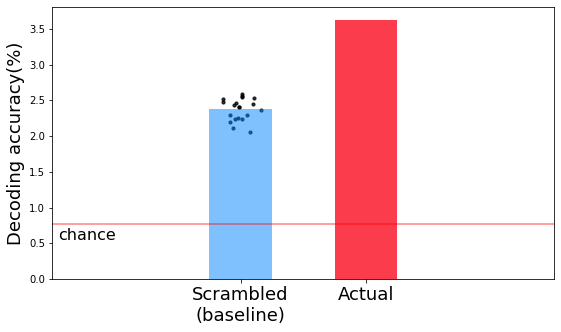

In [283]:
plt.figure(figsize=(9,5), facecolor='w')
plt.bar([1], np.mean(scram_hit_iter), width=0.5, alpha=0.5, color='#0084ff')
x_random = np.random.normal(1, 0.07, size=n_iter)
plt.scatter(x_random, np.mean(scram_hit_iter, axis=1), s=10, alpha=0.8, c='k')

plt.bar([2], np.mean(100*np.array(test_hit)/1310), width=0.5, color='#fa3c4c')
plt.xlim(-0.5,3.5)
plt.axhline((n_top / 1310 * 100), c='r', alpha=0.5, label='chance')
plt.text(-0.5+0.05,(n_top / 1310 * 100)-0.05, s='chance', ha='left', va='top', fontsize=16)
plt.xticks([1,2], ['Scrambled\n(baseline)', 'Actual'], fontsize=18)
plt.ylabel('Decoding accuracy(%)', fontsize=18)

### Decoding the representation of words in context
To improve your decoding model, you can modify the current embedding method. For example, you might think that the interpretation of the word's meaning at the current time step is affected by the words that appear at the preceding time steps. We can examine whether the decoding accuracy can be improved by considering contextual information of a word. 

In this simple example, let us consider the representation of the word at the current time as the weighted sum of the 10 consecutive previous words (including the word itself). 

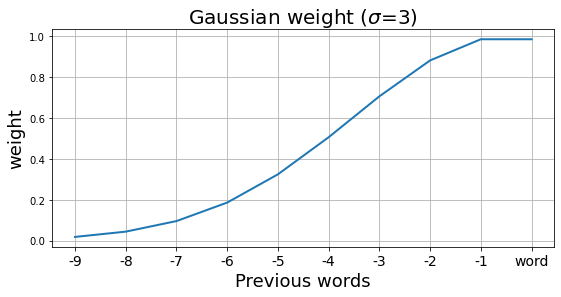

In [358]:
# We apply a Gaussian window to compute the weighted sum of the previous words
n_previous_words = 10

window = signal.gaussian(n_previous_words*2, std=3)[1:n_previous_words + 1]
plt.figure(figsize=(9, 4))
plt.plot(window, lw=2)
plt.title("Gaussian weight ($\sigma$=3)", fontsize=20)
plt.ylabel("weight", fontsize=18)
plt.xticks(np.arange(n_previous_words), ['{}'.format(-n_previous_words+i) for i in range(1, n_previous_words)]+['word'], fontsize=14)
plt.xlabel("Previous words", fontsize=18)
plt.grid()

First, apply Gaussian weights to all time steps.

In [357]:
n_words = word_embedding.shape[0]

word_embedding_context = []
for i in range(n_words):
    if i < n_previous_words:
        weight = signal.gaussian(n_previous_words*2, std=3)[1:n_previous_words + 1][-(i+1):]
        word_embedding_context.append(np.sum([weight[w]*word_embedding.iloc[w, 2:] for w in range(i+1)], axis=0))
    else:
        weight = signal.gaussian(n_previous_words*2, std=3)[1:n_previous_words + 1]
        word_embedding_context.append(np.sum([weight[w]*word_embedding.iloc[i-n_previous_words+w, 2:] for w in range(n_previous_words)], axis=0))

word_embedding_context = pd.concat([word_embedding.loc[:, ['onset', 'word']], pd.DataFrame(word_embedding_context)], axis=1)

paranoia_embedding_context = downsample_embeddings(word_embedding_context)


Next, compare the weighted word vectors with the original word vectors over time.

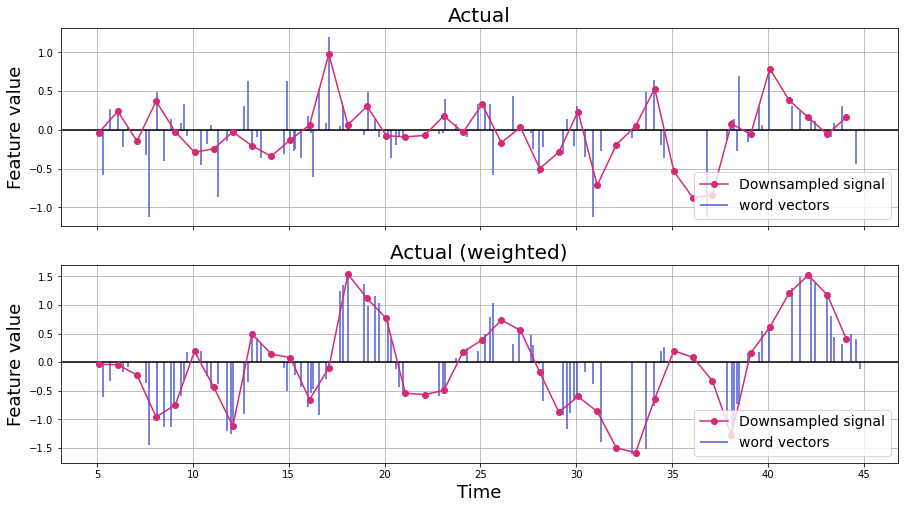

In [359]:
n_words = 100
feature = 0

f,a = plt.subplots(nrows=2, figsize=(15,8), sharex=True)
a[0].axhline(0, c='k')
a[0].vlines(word_embedding['onset'][:n_words], [0], 
           word_embedding.iloc[:n_words, feature + 2], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_embedding['onset'][:n_words], 
                             word_embedding.iloc[:n_words, feature+2], kind='linear')

TR_time = np.arange(np.min(word_embedding['onset'][:n_words]), np.max(word_embedding['onset'][:n_words])) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

a[0].plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')
a[0].legend(loc='lower right', fontsize=14)
a[0].set_ylabel('Feature value', fontsize=18)
a[0].set_title('Actual', fontsize=20)
a[0].grid()

a[1].axhline(0, c='k')
a[1].vlines(word_embedding['onset'][:n_words], [0], 
           word_embedding_context.iloc[:n_words, feature + 2], color='#4f5bd5', label='word vectors')

# Linear interpolation
linear_downsample = interp1d(word_embedding_context['onset'][:n_words], 
                             word_embedding_context.iloc[:n_words, feature+2], kind='linear')

TR_time = np.arange(np.min(word_embedding_context['onset'][:n_words]), np.max(word_embedding_context['onset'][:n_words])) # Specify the number of time points
downsampled_vector = linear_downsample(TR_time)

a[1].plot(TR_time, downsampled_vector, 'o-',color='#d62976', label='Downsampled signal')
a[1].legend(loc='lower right', fontsize=14)
a[1].set_xlabel('Time', fontsize=18)
a[1].set_ylabel('Feature value', fontsize=18)
a[1].set_title('Actual (weighted)', fontsize=20)
plt.grid()

In [360]:
X = fmri_data
Y = zscore(paranoia_embedding_context, axis=0) # Normalize each feature dimension

n_top = 10
LOO = LeaveOneOut()

context_hit = []
# Leave one subject out cross validation
for train_index, test_index in LOO.split(sub_list):
    print("TRAIN sub:", train_index, "TEST sub:", test_index)
    X_train = np.zeros((1310*len(train_index), 268))   # Train X(fMRI): (1310*21, 268)
    y_train = np.zeros((1310*len(train_index), 100))   # Train Y(Text): (1310*21, 100)
    for i, idx in enumerate(train_index):
        X_train[i*1310:(i+1)*1310, :] = X[idx, :, :]
        y_train[i*1310:(i+1)*1310, :] = Y
    X_test = X[test_index[0], :, :]                    # Test X(fMRI): (1310, 268)
    y_test = Y                                         # Test Y(fMRI): (1310, 268)

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    similarity = cosine_similarity(y_pred, y_test)
    
    # Check if the predicted word embedding is ranked within the top 10
    hit = 0
    for j in range(similarity.shape[0]):        
        if j in similarity[j,:].argsort()[-n_top:][::-1]:
            hit += 1
    print('Test decoding acc.: {:0.3f}%'.format(100*hit/1310))
    print(' ')

    context_hit.append(hit)
print(' ')
print('-----------------Average decoding acc. (Context)-----------------')
print('Average acc.: {:0.3f}%'.format((100*np.array(context_hit)/1310).mean()))
print('Chance acc.: {:0.3f}%'.format(n_top / 1310 * 100))

TRAIN sub: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [0]
Test decoding acc.: 4.046%
 
TRAIN sub: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [1]
Test decoding acc.: 2.137%
 
TRAIN sub: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [2]
Test decoding acc.: 1.985%
 
TRAIN sub: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [3]
Test decoding acc.: 5.878%
 
TRAIN sub: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [4]
Test decoding acc.: 3.893%
 
TRAIN sub: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [5]
Test decoding acc.: 2.824%
 
TRAIN sub: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [6]
Test decoding acc.: 1.679%
 
TRAIN sub: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST sub: [7]
Test decoding acc.: 3.511%
 
TRAIN sub: [ 0  1  2  3  4  5  6  7  9 10 11 12 

Text(0, 0.5, 'Decoding accuracy(%)')

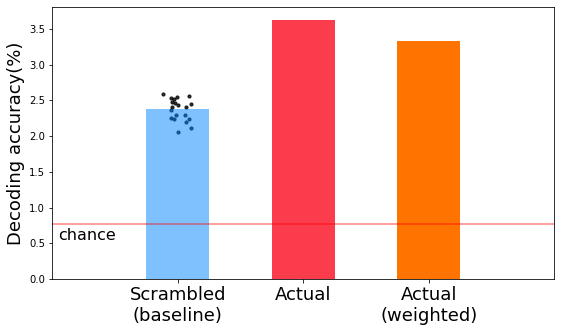

In [361]:
plt.figure(figsize=(9,5), facecolor='w')
plt.bar([1], np.mean(scram_hit_iter), width=0.5, alpha=0.5, color='#0084ff')
x_random = np.random.normal(1, 0.07, size=n_iter)
plt.scatter(x_random, np.mean(scram_hit_iter, axis=1), s=10, alpha=0.8, c='k')

plt.bar([2], np.mean(100*np.array(test_hit)/1310), width=0.5, color='#fa3c4c')
plt.bar([3], np.mean(100*np.array(context_hit)/1310), width=0.5, color='#ff7400')
plt.xlim(0,4)
plt.xticks([1,2,3], ['Scrambled\n(baseline)', 'Actual', 'Actual\n(weighted)'], fontsize=18)
plt.axhline((n_top / 1310 * 100), c='r', alpha=0.5, label='chance')
plt.text(0+0.05,(n_top / 1310 * 100)-0.05, s='chance', ha='left', va='top', fontsize=16)
plt.ylabel('Decoding accuracy(%)', fontsize=18)

If you're interested in improving your model further, you can consider other embedding models that might reflect contextual information more accurately. For instance, [Jain and Huth (2018)](https://doi.org/10.1101/327601) reported encoding models that utilize contextual representations extracted from an LSTM language model. You could also try embedding models based on causal relations between events in stories. 

## 5. Visualize the weight map
This section provides an example of visualizing the weights from a linear model on top of the MNI-averaged template. Here, we visualize the regression coefficients of the first feature. 

In [376]:
feature = 0
reg_coef_image = roi_to_brain(pd.Series(map_coef[0, :]), expand_mask(mask))


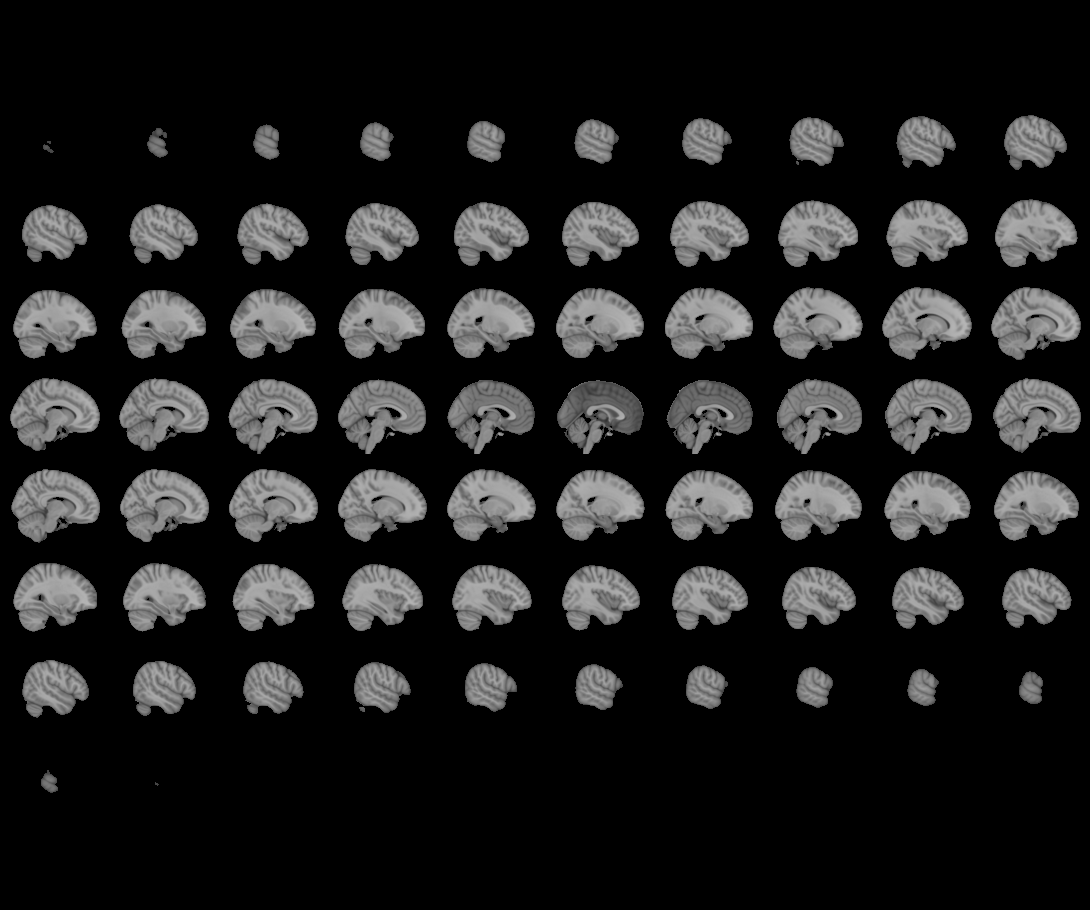
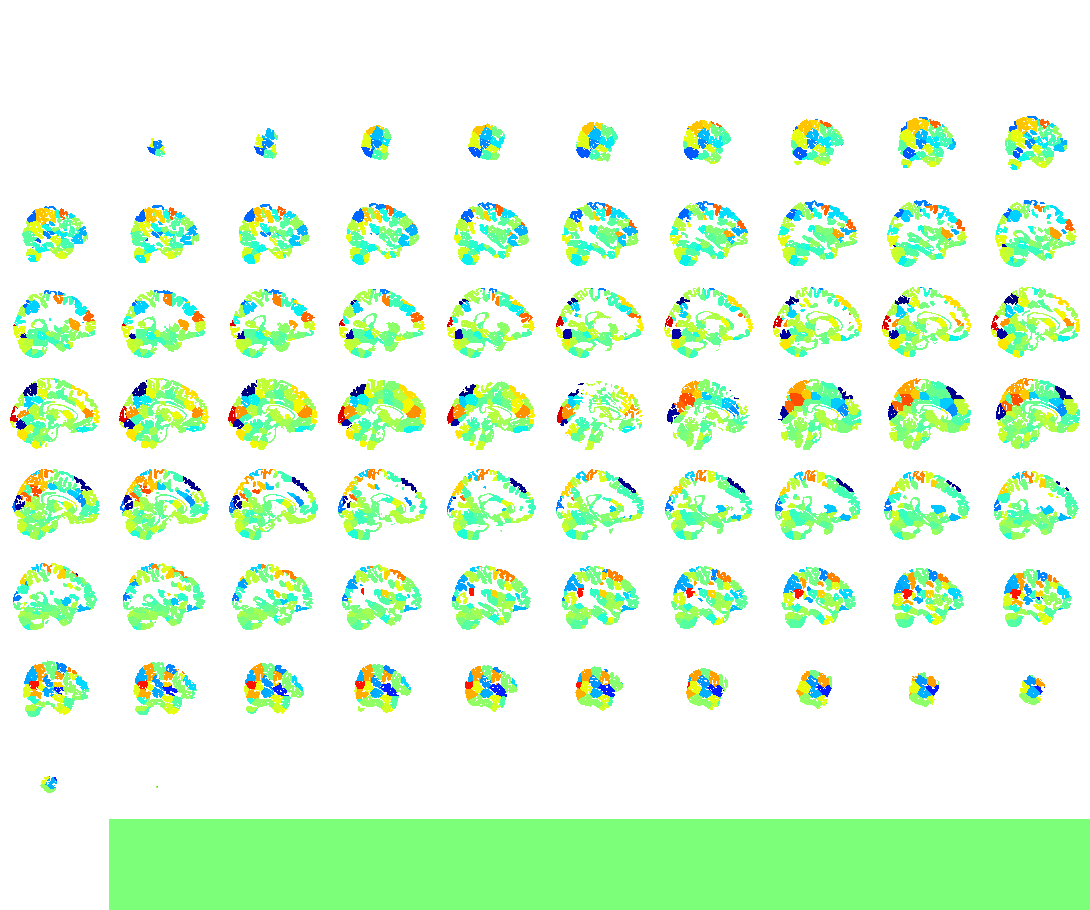

In [375]:
view_img(reg_coef_image.to_nifti(), cmap='jet')

We can also visualize them on a surface map.

In [371]:
view_img_on_surf(reg_coef_image.to_nifti(), cmap='jet')

# Recommended reading 
- Finn, E. S., Corlett, P. R., Chen, G., Bandettini, P. A. Constable, R. T. (2018). Trait paranoia shapes inter-subject synchrony in brain activity during an ambiguous social narrative. Nat Commun 9, 2043 .
- Huth, A. G., de Heer, W. A., Griffiths, T. L., Theunissen, F. E., Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. Nature 532, 453–458.
- Pennington, J. & Socher, R. & Manning, C. (2014). Glove: Global Vectors for Word Representation. EMNLP. 14. 1532-1543.
- Vodrahalli, K., Chen, P. -H., Liang, Y., Baldassano, C., Chen, J., Yong, E., Honey, C., Hasson, U., Ramadge, P., Norman, K. A., Arora, S. (2018). Mapping between fMRI responses to movies and their natural language annotations. NeuroImage 180, 223–231.

# Contributions
Jiwoong Park, Hayoung Song, and Won Mok Shim developed the initial notebook. Luke Chang edited text and code.

In [ ]:
dd